# Import dataset

In [1]:
%load_ext autoreload
%autoreload 2

#import wandb
#from wandb.keras import WandbMetricsLogger
import random
import h5py
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer, Normalizer
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D, BatchNormalization, Input, concatenate
from keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.python.client import device_lib

SEED = 1318
def set_seed(seed=48):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    RANDOM_STATE = 42
set_seed(SEED)

2024-05-12 19:41:18.615243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 19:41:18.615372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 19:41:18.749178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data(path):
    folders = os.listdir(path)
    data = []

    for folder in folders:
        files = os.listdir(os.path.join(path, folder))

        for file in files:
            file_path = os.path.join(path, folder, file)
            image = np.asarray(cv2.imread(file_path))
            data.append([image, folder])

    df = pd.DataFrame(data, columns=['image', 'label'])
    print(f"Found {df.shape[0]} images belonging to {len(df['label'].unique())} classes")

    return df

# Preprocess images
def preprocess_images(images, target_size=(88, 104)):
    processed_images = []
    for img in images:
        img = cv2.resize(img, (target_size[1], target_size[0]))  # Resize to (104, 88)
        processed_images.append(img)
    return np.array(processed_images)

# Remove smallest category
def removeSmallestCategory(dataset, dataset_name):
    value_counts = dataset['label'].value_counts()
    min_count_category = value_counts.idxmin()  # Get the label of the category with the smallest count
    newDataset = dataset[dataset['label'] != min_count_category]
    print("Category removed: "+ min_count_category +" from ", dataset_name)
    return newDataset, min_count_category

def removeSmallestGivenCategory(dataset, dataset_name, category):
    value_counts = dataset['label'].value_counts()
    newDataset = dataset[dataset['label'] != category]
    print("Category removed: "+ category +" from ", dataset_name)
    return newDataset

def mergeSmallestCategories(dataset):
    value_counts = dataset['label'].value_counts()
    min_count_categories = value_counts.nsmallest(2).index
    new_label = min_count_categories[0] + '+' + min_count_categories[1]

    dataset['label'] = dataset['label'].replace({min_count_categories[0]: new_label, min_count_categories[1]: new_label})

    print(f"Categories merged: {min_count_categories[0]} and {min_count_categories[1]} into {new_label}")

    return dataset, min_count_categories[0], min_count_categories[1]

def mergeSmallestGivenCategories(dataset, catagory1, catagory2):
    value_counts = dataset['label'].value_counts()
    min_count_categories = [catagory1, catagory2]
    new_label = min_count_categories[0] + '+' + min_count_categories[1]

    dataset['label'] = dataset['label'].replace({min_count_categories[0]: new_label, min_count_categories[1]: new_label})

    print(f"Categories merged: {min_count_categories[0]} and {min_count_categories[1]} into {new_label}")

    return dataset

# Split into test and train
def split_train_test(dataset):
    dataset_train = pd.DataFrame()
    dataset_test = pd.DataFrame()

    for label, group in dataset.groupby('label'):
        train_size = int(0.8 * len(group))
        train_data = group[:train_size]
        test_data = group[train_size:]

        dataset_train = pd.concat([dataset_train, train_data])
        dataset_test = pd.concat([dataset_test, test_data])

    return dataset_train, dataset_test

# Balance the given dataset with oversampling
def balanceDatasetWOverSamp(dataset):
    value_counts = dataset['label'].value_counts()
    max_count = value_counts.max()
    balanced_data = pd.DataFrame()
    for label, group in dataset.groupby('label'):
        if len(group) < max_count:
            sampling_effect = min(MAX_OVERSAMPLING_SEED * len(group), max_count) / len(group)
            print(f"Category {label}: Sampling effect - {sampling_effect}")
            oversampled_group = group.sample(min(MAX_OVERSAMPLING_SEED * len(group), max_count), replace=True, random_state=42)
            balanced_data = pd.concat([balanced_data, oversampled_group])
        else:
            balanced_data = pd.concat([balanced_data, group.sample(max_count)])

    return balanced_data

# Balance the given dataset with undersampling
def balanceDataset(dataset):
    value_counts = dataset['label'].value_counts()
    min_count = value_counts.min()
    balanced_data = pd.DataFrame()

    for label, group in dataset.groupby('label'):
        undersampled_group = group.sample(min_count, random_state=42)
        balanced_data = pd.concat([balanced_data, undersampled_group])

    return balanced_data

def calculateFalsePositive(conf_matrix, class_names):
    # Calculate the false positive rate for each class
    # False Positive Rate = FP / (FP + TN)
    false_positive_rate = []
    for i in range(len(conf_matrix)):
        fp = sum(conf_matrix[:, i]) - conf_matrix[i, i]
        tn = np.sum(conf_matrix) - np.sum(conf_matrix[i, :]) - np.sum(conf_matrix[:, i]) + conf_matrix[i, i]
        fpr = fp / (fp + tn)
        false_positive_rate.append((class_names[i], fpr))
    return false_positive_rate

def calculateFalseNegative(conf_matrix, class_names):
    # Calculate the false negative rate for each class
    # False Negative Rate = FN / (FN + TP)
    false_negative_rate = []
    for i in range(len(conf_matrix)):
        fn = sum(conf_matrix[i, :]) - conf_matrix[i, i]
        tp = conf_matrix[i, i]
        fnr = fn / (fn + tp)
        false_negative_rate.append((class_names[i], fnr))
    return false_negative_rate

In [3]:
#! pip install -q kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
#!unzip '/content/alzheimers-dataset-4-class-of-images.zip' -d 'kaggle'

In [4]:
#! pip install wandb
#! wandb login

Found 1952 images belonging to 4 classes


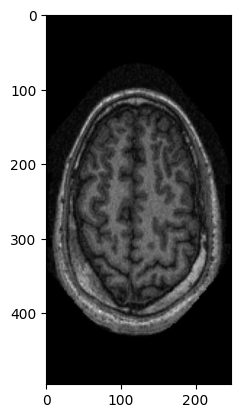

In [5]:
def loadAdditionalData(path, isBW=False, num_images=488):
    """
    Imports a specified number of images from each folder and returns a pandas DataFrame with the image and label columns.

    Parameters
    ----------
    path : str
        Path to the dataset.
    isBW : bool, optional
        Whether to read the images as grayscale. The default is True.
    num_images : int, optional
        Number of images to retrieve from each folder. The default is 448.

    Returns
    -------
    df : pandas DataFrame
        DataFrame with the image and label columns.

    """
    # Get the list of folders in the directory
    folders = os.listdir(path)
    data = []
    
    for folder in folders:
        # Get the list of files in the folder
        files = os.listdir(os.path.join(path, folder))

        # Retrieve the specified number of images
        for file in files[:num_images]:
            # Get the path to the file
            filePath = os.path.join(path, folder, file)
            
            random.Random(42).shuffle(files)

            # Read the image as grayscale or not
            if isBW:
                image = np.asarray(cv2.imread(filePath, cv2.IMREAD_GRAYSCALE))
            else:
                image = np.asarray(cv2.imread(filePath))

            # Append the image data and the label to the list
            data.append([image, folder])

    df = pd.DataFrame(data, columns=['image', 'label'])
    print(f"Found {df.shape[0]} images belonging to {len(df['label'].unique())} classes")

    return df

ADDITIONAL = loadAdditionalData('/kaggle/input/imagesoasis/Data/')

# Correct the names of the classes
NEW_NAMES = {'Non Demented': 'NonDemented', 'Very mild Dementia': 'VeryMildDemented', 'Mild Dementia': 'MildDemented', 'Moderate Dementia': 'ModerateDemented'}
ADDITIONAL['label'] = ADDITIONAL['label'].map(NEW_NAMES)

# Rotate the images to the correct orientation (90 degrees to the left)
ADDITIONAL['image'] = ADDITIONAL['image'].apply(lambda x: np.rot90(x))

# See the change
plt.imshow(ADDITIONAL['image'][0], cmap='gray')

# Split the data
TRAIN_ADDITIONAL, TEST_ADDITIONAL = train_test_split(ADDITIONAL, test_size=0.2, random_state=42, stratify=ADDITIONAL['label'])


# CNN model

In [6]:
# Set up constants
DO_LOAD = True
DO_PREPROCESS = True
DO_BALANCE = True
DO_REMOVE_SMALLEST_CATEGORY = False
DO_MERGE_SMALLEST_CATEGORIES = False
DO_PREPROCESSDATA = True
DO_RGB = True

BATCHSIZE = 64
N_EPOCHS = 30
N_CLASSES = 4
MAX_OVERSAMPLING_SEED = 4

# Initialize a W&B run
#wandb.init(
  # Set the project where this run will be logged
#  project="GroupProject - Alzheimer's CNN",
  # We pass a run name (otherwise it will be randomly assigned, like sunshine-lollypop-10)
#  name=f"experiment_{run}",
  # Track hyperparameters and run metadata
#  config={
  #"learning_rate": 0.02,
#  "architecture": "CNN",
#  "dataset": "Alzheimer's (4 classes)",
#  "epochs": N_EPOCHS,
#  })

# Load the data
data_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"

if DO_LOAD:
    print("Loading data...")
    if DO_RGB:
        TRAIN = load_data(os.path.join(data_dir, 'train'))
        TEST = load_data(os.path.join(data_dir, 'test'))
    else:
        TRAIN = load_data(os.path.join(data_dir, 'train_gray'))
        TEST = load_data(os.path.join(data_dir, 'test_gray'))
    print("Data imported.")

# Original sizes of TRAIN and TEST datasets
train_size = len(TRAIN)
test_size = len(TEST)
print(f"Size of TRAIN dataset: {train_size}")
print(f"Size of TEST dataset: {test_size}")

# Print size of each category in TRAIN dataset before rebalancing
print("Category sizes in TRAIN dataset before rebalancing:")
print(TRAIN['label'].value_counts())

# Balance and split the TRAIN dataset
train_data_train, train_data_test = split_train_test(TRAIN)

if DO_BALANCE:
    train_data_train = balanceDatasetWOverSamp(train_data_train)
    train_data_test = balanceDataset(train_data_test)
else:
    print("Skipping balancing for TRAIN dataset...")

# Print size of each category in TRAIN dataset after rebalancing
print("Category sizes in TRAIN dataset after rebalancing (excluding testing portion):")
print(train_data_train['label'].value_counts())
print("Category sizes of test portion of TRAIN dataset:")
print(train_data_test['label'].value_counts())

# Print size of each category in TEST dataset before rebalancing
print("Category sizes in TEST dataset before rebalancing:")
print(TEST['label'].value_counts())

# Balance and split the TEST dataset
test_data_train, test_data_test = split_train_test(TEST)

if DO_BALANCE:
    test_data_train = balanceDatasetWOverSamp(test_data_train)
    test_data_test = balanceDataset(test_data_test)
else:
    print("Skipping balancing for TEST dataset...")

# Print size of each category in TEST dataset after rebalancing
print("Category sizes in TEST dataset after rebalancing (excluding testing portion):")
print(test_data_train['label'].value_counts())
print("Catagory sizes of test portion of TEST dataset:")
print(test_data_test['label'].value_counts())

# Combine the balanced TRAIN and TEST datasets
print("Combining balanced TRAIN and TEST datasets...")
combined_train = pd.concat([train_data_train, test_data_train])
combined_test = pd.concat([train_data_test, test_data_test])

############## Add Additional Data ############################
combined_train = pd.concat([combined_train, TRAIN_ADDITIONAL])
combined_test = pd.concat([combined_test, TEST_ADDITIONAL])
###############################################################


if DO_REMOVE_SMALLEST_CATEGORY:
    print("Removing smallest category...")
    combined_train, smallestCat = removeSmallestCategory(combined_train, "TRAIN")
    combined_test = removeSmallestGivenCategory(combined_test, "TEST", smallestCat)
    N_CLASSES = N_CLASSES - 1
    print("Done!")

if DO_MERGE_SMALLEST_CATEGORIES:
    print("Merging smallest categories...")
    # Do it twice to turn the problem into a binary classification
    combined_train, cat1, cat2 = mergeSmallestCategories(combined_train)
    combined_test = mergeSmallestGivenCategories(combined_test, cat1, cat2)
    combined_train, cat1, cat2 = mergeSmallestCategories(combined_train)
    combined_test = mergeSmallestGivenCategories(combined_test, cat1, cat2)
    N_CLASSES = N_CLASSES - 2
    print("Done!")


print("Final combined TRAIN dataset:")
print(combined_train['label'].value_counts())
print("Final combined TEST dataset:")
print(combined_test['label'].value_counts())

# Shuffle the combined datasets
print("Shuffling combined TRAIN and TEST datasets...")
combined_train = combined_train.sample(frac=1).reset_index(drop=True)
combined_test = combined_test.sample(frac=1).reset_index(drop=True)

# Separate images and labels
TRAIN_processed = preprocess_images(combined_train['image'].values)
TEST_processed = preprocess_images(combined_test['image'].values)

# One-hot encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(combined_train['label'])
train_labels_categorical = to_categorical(train_labels_encoded, num_classes=N_CLASSES)
test_labels_encoded = label_encoder.transform(combined_test['label'])
test_labels_categorical = to_categorical(test_labels_encoded, num_classes=N_CLASSES)
train_labels_categorical_tensor = tf.constant(train_labels_categorical)
test_labels_categorical_tensor = tf.constant(test_labels_categorical)

TRAIN_tensor = tf.convert_to_tensor(TRAIN_processed)
TEST_tensor = tf.convert_to_tensor(TEST_processed)

# Definition of blocks of layers
def preprocessingBlock(rotation=0.2, zoom=0.2, contrast=0.2):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Rescaling(1./255))
    #block.add(tf.keras.layers.RandomFlip("horizontal"))
    block.add(tf.keras.layers.RandomContrast(contrast))
    block.add(tf.keras.layers.RandomZoom(zoom))
    block.add(tf.keras.layers.RandomRotation(rotation))
    return block

def denseBlock(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


# Define the model architecture
input_layer = keras.layers.Input(shape=(88, 104, 3)) #88 x 104 px with three colour layers (RGB) for JPEG
aug = preprocessingBlock(rotation=0.1, zoom=0.1, contrast=0.1)(input_layer)
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(aug)
pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)
flatten = keras.layers.Flatten()(pool3)
dense1 = keras.layers.Dense(128, activation='relu')(flatten)
output_layer = Dense(N_CLASSES, activation='softmax')(dense1)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy',
  metrics=[
    keras.metrics.CategoricalAccuracy(),
    keras.metrics.F1Score(average = 'weighted'),
    keras.metrics.FalseNegatives(),
    keras.metrics.FalsePositives()
    #keras.metrics.IoU(),
    ])


# Pretrained model - Xception
inputs = keras.layers.Input(shape=(88, 104, 3))
aug = preprocessingBlock(rotation=0.1, zoom=0.1, contrast=0.1)(inputs)
xception = keras.applications.Xception(include_top=False, weights='imagenet')(aug)
globalavg = keras.layers.GlobalAveragePooling2D()(xception)
denseblock1 = denseBlock(1024, 0.3)(globalavg)
denseblock2 = denseBlock(512, 0.2)(denseblock1)
denseblock3 = denseBlock(128, 0.2)(denseblock2)
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(denseblock3)
pretrained = keras.Model(inputs, outputs)

pretrained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
  metrics=[
    keras.metrics.CategoricalAccuracy(),
    keras.metrics.F1Score(average = 'weighted'),
    keras.metrics.FalseNegatives(),
    keras.metrics.FalsePositives()
    #keras.metrics.IoU(),
    ])

# Train the model on the training data and validate on the testing data

######## Adding Callbacks
CALLBACKS1 = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1, restore_best_weights=True, monitor = 'val_f1_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=15, min_lr=0.00001, verbose=1),
]

CALLBACKS2 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=0.00001, verbose=1),
]
model.fit(TRAIN_tensor, train_labels_categorical_tensor, validation_data=(TEST_tensor, test_labels_categorical_tensor), epochs=N_EPOCHS, callbacks = CALLBACKS1)
pretrained.fit(TRAIN_tensor, train_labels_categorical_tensor, validation_data=(TEST_tensor, test_labels_categorical_tensor), epochs=N_EPOCHS, callbacks = CALLBACKS2)

# Close the W&B run (Might not save the final scores of the model, as only taking the last training values, not the final scores of the model)
#run.finish()

# Evaluate the model on the testing data
test_loss, test_accuracy, test_f1, test_fn, test_fp = model.evaluate(TEST_tensor, test_labels_categorical_tensor, batch_size=BATCHSIZE)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

test_loss_p, test_accuracy_p, test_f1_p, test_fn_p, test_fp_p = pretrained.evaluate(TEST_tensor, test_labels_categorical_tensor, batch_size=BATCHSIZE)
print(f'Xception Test loss: {test_loss_p}, Xception Test accuracy: {test_accuracy_p}')

# Make predictions on the test data
predictions = model.predict(TEST_tensor)
predicted_labels = np.argmax(predictions, axis=1)
# Convert one-hot encoded test labels back to categorical labels
test_labels = np.argmax(test_labels_categorical, axis=1)
# Calculate the F1 score
f1score = f1_score(test_labels, predicted_labels, average='weighted')
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print('\nCNN:')
predictions_p = pretrained.predict(TEST_tensor)
predicted_labels_p = np.argmax(predictions_p, axis=1)
f1score_p = f1_score(test_labels, predicted_labels_p, average='weighted')
conf_matrix_p = confusion_matrix(test_labels, predicted_labels_p)

# After calculating the confusion matrix
class_names = combined_train['label'].unique().tolist()
false_positive_rate = calculateFalsePositive(conf_matrix, class_names)
false_negative_rate = calculateFalseNegative(conf_matrix, class_names)
print(f'False Positive Rate for each class: {false_positive_rate}')
print(f'False Negative Rate for each class: {false_negative_rate}')

print(f'F1 Score: {f1score}')

# After calculating the confusion matrix
print('\nXception:')
false_positive_rate_p = calculateFalsePositive(conf_matrix_p, class_names)
false_negative_rate_p = calculateFalseNegative(conf_matrix_p, class_names)
print(f'False Positive Rate for each class: {false_positive_rate_p}')
print(f'False Negative Rate for each class: {false_negative_rate_p}')

print(f'F1 Score: {f1score_p}')

# Save the trained model
model.save('my_model.keras')
pretrained.save('xception_model.keras')

Loading data...
Found 5121 images belonging to 4 classes
Found 1279 images belonging to 4 classes
Data imported.
Size of TRAIN dataset: 5121
Size of TEST dataset: 1279
Category sizes in TRAIN dataset before rebalancing:
label
NonDemented         2560
VeryMildDemented    1792
MildDemented         717
ModerateDemented      52
Name: count, dtype: int64
Category MildDemented: Sampling effect - 3.574171029668412
Category ModerateDemented: Sampling effect - 4.0
Category VeryMildDemented: Sampling effect - 1.4291695743196091
Category sizes in TRAIN dataset after rebalancing (excluding testing portion):
label
MildDemented        2048
NonDemented         2048
VeryMildDemented    2048
ModerateDemented     164
Name: count, dtype: int64
Category sizes of test portion of TRAIN dataset:
label
MildDemented        11
ModerateDemented    11
NonDemented         11
VeryMildDemented    11
Name: count, dtype: int64
Category sizes in TEST dataset before rebalancing:
label
NonDemented         640
VeryMildDem

# Binary Classification

In [7]:
# Set up constants again
N_CLASSES = 4
MAX_OVERSAMPLING_SEED = 4


if DO_LOAD:
    print("Loading data...")
    if DO_RGB:
        TRAIN = load_data(os.path.join(data_dir, 'train'))
        TEST = load_data(os.path.join(data_dir, 'test'))
    else:
        TRAIN = load_data(os.path.join(data_dir, 'train_gray'))
        TEST = load_data(os.path.join(data_dir, 'test_gray'))
    print("Data imported.")

# Original sizes of TRAIN and TEST datasets
train_size = len(TRAIN)
test_size = len(TEST)
print(f"Size of TRAIN dataset: {train_size}")
print(f"Size of TEST dataset: {test_size}")

# Print size of each category in TRAIN dataset before rebalancing
print("Category sizes in TRAIN dataset before rebalancing:")
print(TRAIN['label'].value_counts())

# Balance and split the TRAIN dataset
train_data_train, train_data_test = split_train_test(TRAIN)

if DO_BALANCE:
    train_data_train = balanceDatasetWOverSamp(train_data_train)
    train_data_test = balanceDataset(train_data_test)
else:
    print("Skipping balancing for TRAIN dataset...")

# Print size of each category in TRAIN dataset after rebalancing
print("Category sizes in TRAIN dataset after rebalancing (excluding testing portion):")
print(train_data_train['label'].value_counts())
print("Category sizes of test portion of TRAIN dataset:")
print(train_data_test['label'].value_counts())

# Print size of each category in TEST dataset before rebalancing
print("Category sizes in TEST dataset before rebalancing:")
print(TEST['label'].value_counts())

# Balance and split the TEST dataset
test_data_train, test_data_test = split_train_test(TEST)

if DO_BALANCE:
    test_data_train = balanceDatasetWOverSamp(test_data_train)
    test_data_test = balanceDataset(test_data_test)
else:
    print("Skipping balancing for TEST dataset...")

# Print size of each category in TEST dataset after rebalancing
print("Category sizes in TEST dataset after rebalancing (excluding testing portion):")
print(test_data_train['label'].value_counts())
print("Catagory sizes of test portion of TEST dataset:")
print(test_data_test['label'].value_counts())

# Combine the balanced TRAIN and TEST datasets
print("Combining balanced TRAIN and TEST datasets...")
combined_train = pd.concat([train_data_train, test_data_train])
combined_test = pd.concat([train_data_test, test_data_test])

############## Add Additional Data ############################
combined_train = pd.concat([combined_train, TRAIN_ADDITIONAL])
combined_test = pd.concat([combined_test, TEST_ADDITIONAL])
###############################################################


if DO_REMOVE_SMALLEST_CATEGORY:
    print("Removing smallest category...")
    combined_train, smallestCat = removeSmallestCategory(combined_train, "TRAIN")
    combined_test = removeSmallestGivenCategory(combined_test, "TEST", smallestCat)
    N_CLASSES = N_CLASSES - 1
    print("Done!")

if DO_MERGE_SMALLEST_CATEGORIES:
    print("Merging smallest categories...")
    combined_train, cat1, cat2 = mergeSmallestCategories(combined_train)
    combined_test = mergeSmallestGivenCategories(combined_test, cat1, cat2)
    combined_train, cat1, cat2 = mergeSmallestCategories(combined_train)
    combined_test = mergeSmallestGivenCategories(combined_test, cat1, cat2)
    N_CLASSES = N_CLASSES - 2
    print("Done!")


print("Final combined TRAIN dataset:")
print(combined_train['label'].value_counts())
print("Final combined TEST dataset:")
print(combined_test['label'].value_counts())

# Shuffle the combined datasets
print("Shuffling combined TRAIN and TEST datasets...")
combined_train = combined_train.sample(frac=1).reset_index(drop=True)
combined_test = combined_test.sample(frac=1).reset_index(drop=True)

# Separate images and labels
TRAIN_processed = preprocess_images(combined_train['image'].values)
TEST_processed = preprocess_images(combined_test['image'].values)

# One-hot encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(combined_train['label'])
train_labels_categorical = to_categorical(train_labels_encoded, num_classes=N_CLASSES)
test_labels_encoded = label_encoder.transform(combined_test['label'])
test_labels_categorical = to_categorical(test_labels_encoded, num_classes=N_CLASSES)
train_labels_categorical_tensor = tf.constant(train_labels_categorical)
test_labels_categorical_tensor = tf.constant(test_labels_categorical)

TRAIN_tensor = tf.convert_to_tensor(TRAIN_processed)
TEST_tensor = tf.convert_to_tensor(TEST_processed)

# Definition of blocks of layers
def preprocessingBlock(rotation=0.2, zoom=0.2, contrast=0.2):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Rescaling(1./255))
    #block.add(tf.keras.layers.RandomFlip("horizontal"))
    block.add(tf.keras.layers.RandomContrast(contrast))
    block.add(tf.keras.layers.RandomZoom(zoom))
    block.add(tf.keras.layers.RandomRotation(rotation))
    return block

def denseBlock(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


# Define the model architecture
input_layer = keras.layers.Input(shape=(88, 104, 3)) #88 x 104 px with three colour layers (RGB) for JPEG
aug = preprocessingBlock(rotation=0.1, zoom=0.1, contrast=0.1)(input_layer)
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(aug)
pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)
flatten = keras.layers.Flatten()(pool3)
dense1 = keras.layers.Dense(128, activation='relu')(flatten)
output_layer = Dense(N_CLASSES, activation='softmax')(dense1)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy',
  metrics=[
    keras.metrics.CategoricalAccuracy(),
    keras.metrics.F1Score(average = 'weighted'),
    keras.metrics.FalseNegatives(),
    keras.metrics.FalsePositives()
    #keras.metrics.IoU(),
    ])


# Pretrained model - Xception
inputs = keras.layers.Input(shape=(88, 104, 3))
aug = preprocessingBlock(rotation=0.1, zoom=0.1, contrast=0.1)(inputs)
xception = keras.applications.Xception(include_top=False, weights='imagenet')(aug)
globalavg = keras.layers.GlobalAveragePooling2D()(xception)
denseblock1 = denseBlock(1024, 0.3)(globalavg)
denseblock2 = denseBlock(512, 0.2)(denseblock1)
denseblock3 = denseBlock(128, 0.2)(denseblock2)
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(denseblock3)
pretrained = keras.Model(inputs, outputs)

pretrained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
  metrics=[
    keras.metrics.CategoricalAccuracy(),
    keras.metrics.F1Score(average = 'weighted'),
    keras.metrics.FalseNegatives(),
    keras.metrics.FalsePositives()
    #keras.metrics.IoU(),
    ])

# Train the model on the training data and validate on the testing data

######## Adding Callbacks
CALLBACKS1 = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1, restore_best_weights=True, monitor = 'val_f1_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=15, min_lr=0.00001, verbose=1),
]

CALLBACKS2 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=0.00001, verbose=1),
]
model.fit(TRAIN_tensor, train_labels_categorical_tensor, validation_data=(TEST_tensor, test_labels_categorical_tensor), epochs=N_EPOCHS, callbacks = CALLBACKS1)
pretrained.fit(TRAIN_tensor, train_labels_categorical_tensor, validation_data=(TEST_tensor, test_labels_categorical_tensor), epochs=N_EPOCHS, callbacks = CALLBACKS2)

# Close the W&B run (Might not save the final scores of the model, as only taking the last training values, not the final scores of the model)
#run.finish()

# Evaluate the model on the testing data
test_loss, test_accuracy, test_f1, test_fn, test_fp = model.evaluate(TEST_tensor, test_labels_categorical_tensor, batch_size=BATCHSIZE)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

test_loss_p, test_accuracy_p, test_f1_p, test_fn_p, test_fp_p = pretrained.evaluate(TEST_tensor, test_labels_categorical_tensor, batch_size=BATCHSIZE)
print(f'Xception Test loss: {test_loss_p}, Xception Test accuracy: {test_accuracy_p}')

# Make predictions on the test data
predictions = model.predict(TEST_tensor)
predicted_labels = np.argmax(predictions, axis=1)
# Convert one-hot encoded test labels back to categorical labels
test_labels = np.argmax(test_labels_categorical, axis=1)
# Calculate the F1 score
f1score = f1_score(test_labels, predicted_labels, average='weighted')
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print('\nCNN:')
predictions_p = pretrained.predict(TEST_tensor)
predicted_labels_p = np.argmax(predictions_p, axis=1)
f1score_p = f1_score(test_labels, predicted_labels_p, average='weighted')
conf_matrix_p = confusion_matrix(test_labels, predicted_labels_p)

# After calculating the confusion matrix
class_names = combined_train['label'].unique().tolist()
false_positive_rate = calculateFalsePositive(conf_matrix, class_names)
false_negative_rate = calculateFalseNegative(conf_matrix, class_names)
print(f'False Positive Rate for each class: {false_positive_rate}')
print(f'False Negative Rate for each class: {false_negative_rate}')

print(f'F1 Score: {f1score}')

# After calculating the confusion matrix
print('\nXception:')
false_positive_rate_p = calculateFalsePositive(conf_matrix_p, class_names)
false_negative_rate_p = calculateFalseNegative(conf_matrix_p, class_names)
print(f'False Positive Rate for each class: {false_positive_rate_p}')
print(f'False Negative Rate for each class: {false_negative_rate_p}')

print(f'F1 Score: {f1score_p}')

# Save the trained model
model.save('my_model_b.keras')
pretrained.save('xception_model_b.keras')

Loading data...
Found 5121 images belonging to 4 classes
Found 1279 images belonging to 4 classes
Data imported.
Size of TRAIN dataset: 5121
Size of TEST dataset: 1279
Category sizes in TRAIN dataset before rebalancing:
label
NonDemented         2560
VeryMildDemented    1792
MildDemented         717
ModerateDemented      52
Name: count, dtype: int64
Category MildDemented: Sampling effect - 3.574171029668412
Category ModerateDemented: Sampling effect - 4.0
Category VeryMildDemented: Sampling effect - 1.4291695743196091
Category sizes in TRAIN dataset after rebalancing (excluding testing portion):
label
MildDemented        2048
NonDemented         2048
VeryMildDemented    2048
ModerateDemented     164
Name: count, dtype: int64
Category sizes of test portion of TRAIN dataset:
label
MildDemented        11
ModerateDemented    11
NonDemented         11
VeryMildDemented    11
Name: count, dtype: int64
Category sizes in TEST dataset before rebalancing:
label
NonDemented         640
VeryMildDem

# Final Look at the Models

In [8]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 88, 104, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 88, 104, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 86, 102, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 51, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 49, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 11, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,622,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,147,726 (19.64 MB)

 Trainable params: 1,715,908 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,431,818 (13.09 MB)

In [9]:
pretrained.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 88, 104, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 88, 104, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 3, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 1024)           │     2,102,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 128)            │        66,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,556,166 (269.15 MB)

 Trainable params: 23,499,436 (89.64 MB)

 Non-trainable params: 57,856 (226.00 KB)

 Optimizer params: 46,998,874 (179.29 MB)

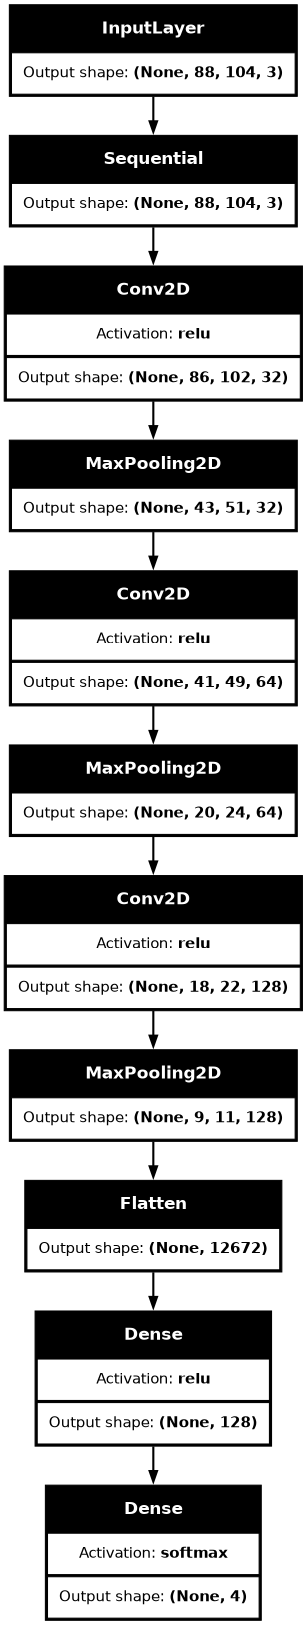

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=76,
    show_layer_activations=True,
    show_trainable=False)

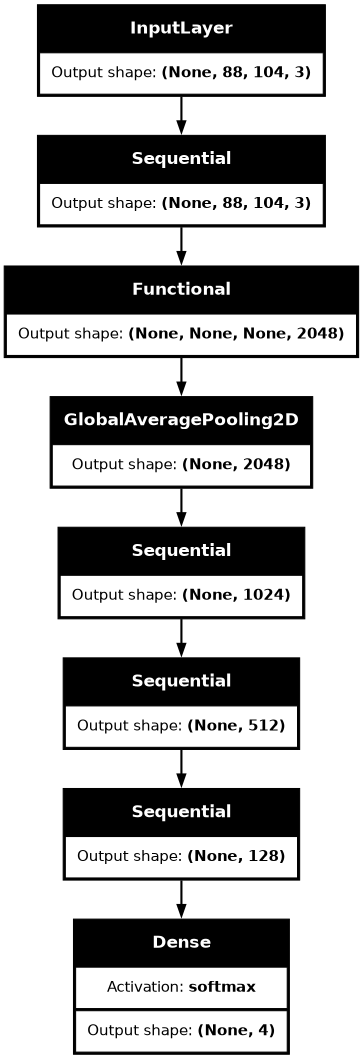

In [11]:
tf.keras.utils.plot_model(
    pretrained,
    to_file='pretrained.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=76,
    show_layer_activations=True,
    show_trainable=False)